# Importation des librairies

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importer les données

In [192]:
data = pd.read_csv('./data2.csv', sep=";")

## Mise en forme Série Temporelle

In [194]:
#  Séléectionner les bonnes colonnes
data = data.iloc[:, [0, 1, 6]].to_numpy()

# Mettre en Serie temporelle
time_serie = pd.Series(data[:, 2], dtype='float64')

# Retirer les valeurs vides
time_serie = time_serie.dropna()

# Afficher la série temporelle

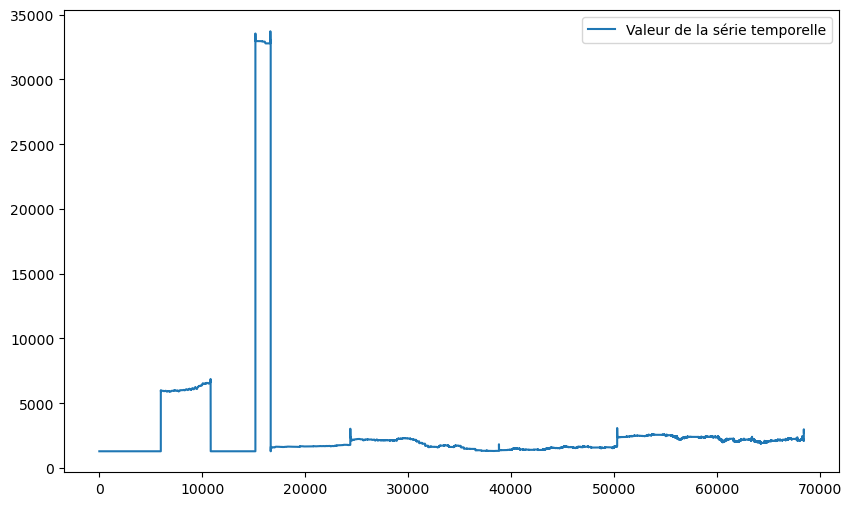

In [196]:
plt.figure(figsize=(10, 6))
plt.plot(time_serie, label='Valeur de la série temporelle')
plt.legend()
plt.show()

On observe que les données sont corrompues.

Sur le début de la plage de données, on observe des paliers de valeurs, celles si ne varient pas ou peu et sont subitement projetées sur d'autres valeurs:

1) entre 0 et 10 000 on a un pic qui passe de 1 280 à environ 6 500
2) entre 15 000 et 20 000 on a un pic qui passe de 1 280 à 32 770

Un nettoyage des données se présente comme nécéssaire 

# Nettoyage des données

## On enlève le début

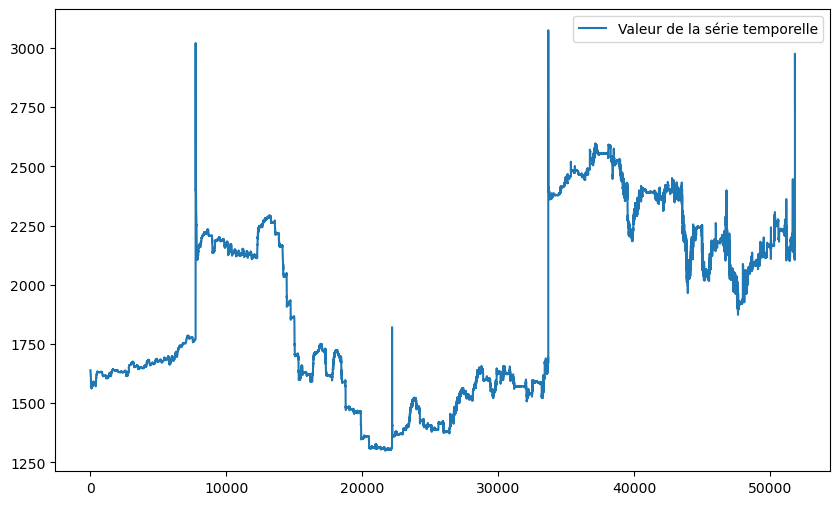

In [198]:
# D'après la base de donnée on obtient cet indice
data_crop = data[16656:, 2] 

# Transformation en série temporelle
time_serie_crop = pd.Series(data_crop, dtype='float64')

# Affichage de la série
plt.figure(figsize=(10, 6))
plt.plot(time_serie_crop, label='Valeur de la série temporelle')
plt.legend()
plt.show()

On remarque qu'il nous reste des pics qui indiqueraient des discontinuités. On va donc commencer par suppriemr ces valeurs aberrantes.

## On enlève les pics

### On detecte où sont les pics 

In [91]:
# Pierre
def detect_pic(arr, seuil=100):
    pic_indices = []
    
    # Parcours des valeurs de la série
    for i in range(1, len(arr) - 1):
        
        # on regarde si la différence entre les 2 valeurs sont plus grandes en valeur absolue que le seuil
        # si oui on considère qu'il y a un pic 
        if arr[i] < arr[i + 1] - seuil or arr[i] > arr[i + 1] + seuil:
            pic_indices.append(i-1) 
            
    return pic_indices

In [201]:
# Ines
def detect_pic(data, seuil=100):
    pic_indices = []
    offset_indices = []
    
    # Parcours des valeurs de la série
    for i in range(1, len(data) - 2):
        
        # on regarde si la différence entre les 2 valeurs est plus grande en valeur absolue que le seuil
        if np.abs(data[i] - data[i+1]) >= seuil :
            # si le saut suivant est aussi supérieur à un pic alors ceci est une valeur aberrante
            if np.abs(data[i+1] - data[i+2]) >= seuil : 
                pic_indices.append(i+1) 
            # sinon on considère qu'il y a un problème d'offset
            else : 
                offset_indices.append(i+1) 
        
    return pic_indices, offset_indices

In [203]:
pic, offset = detect_pic(data_crop)

print("Nombre de pics détectés :", len(pic))
print("Nombre d'offset détectés :", len(offset))
print("Indices des pics :", pic)
print("Indices des offset :", offset)
print("Valeurs des pics :", data_crop[pic])

Nombre de pics détectés : 15
Nombre d'offset détectés : 11
Indices des pics : [7733, 7734, 7735, 22178, 33666, 33667, 33668, 51166, 51167, 51168, 51644, 51645, 51646, 51803, 51804]
Indices des offset : [7736, 22179, 33669, 45008, 45982, 46699, 46781, 50274, 51169, 51647, 51805]
Valeurs des pics : [2325 3021 2849 1821 3075 2778 2345 2123 2362 2255 2342 2206 2446 2976
 2221]


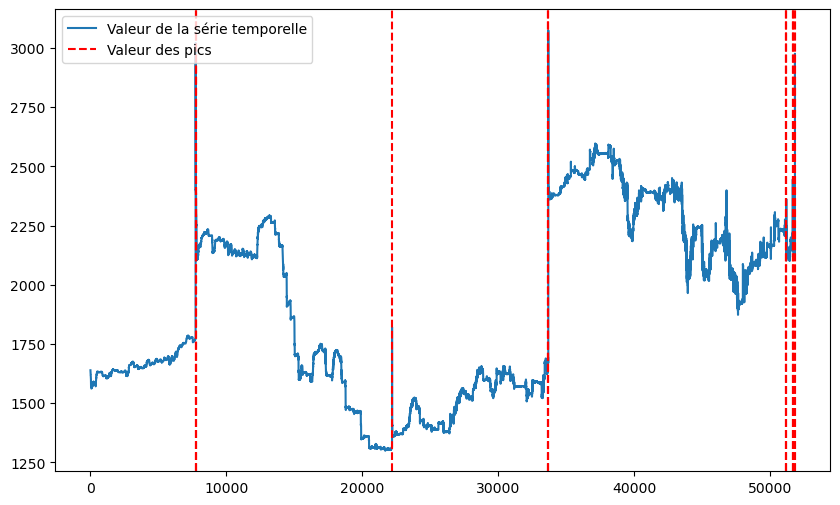

In [205]:
# Affichage des pics sur notre série temporelle pour vérifier si c'est cohérent 

plt.figure(figsize=(10, 6))
plt.plot(time_serie_crop, label='Valeur de la série temporelle')

# Ajout des barres verticales correspondant aux pics
for i,x in enumerate(pic):
    if i == 0:
        plt.axvline(x=x, color='red', linestyle='--', label='Valeur des pics')
    else:
        plt.axvline(x=x, color='red', linestyle='--')

plt.legend(loc='upper left')
plt.show()

In [55]:
# def delete_pic(arr, indices) :
#    data_clean = arr
#    for i in indices:
#        data_clean = [x - arr[i-1] for x in arr[i:]]
#        # print(i,arr[i])
#    return data_clean

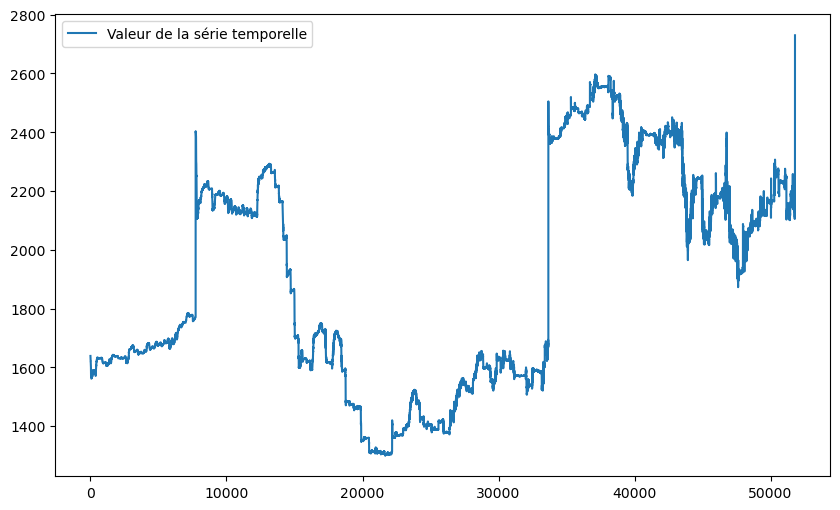

In [207]:
# Suppression des pics
data_clean = np.delete(data_crop, pic)

# Transformation en série temporelle
time_serie_clean = pd.Series(data_clean, dtype='float64')

# Affichage de la série
plt.figure(figsize=(10, 6))
plt.plot(time_serie_clean, label='Valeur de la série temporelle')
plt.legend()
plt.show()

In [209]:
# On vérifie qu'on a que des offset maintenant
pic, offset = detect_pic(data_clean)

print("Nombre de pics détectés :", len(pic))
print("Nombre d'offset détectés :", len(offset))
print("Indices des pics :", pic)
print("Indices des offset :", offset)
print("Valeurs des pics :", data_clean[pic])

Nombre de pics détectés : 0
Nombre d'offset détectés : 10
Indices des pics : []
Indices des offset : [7733, 22175, 33662, 45001, 45975, 46692, 46774, 50267, 51159, 51790]
Valeurs des pics : []


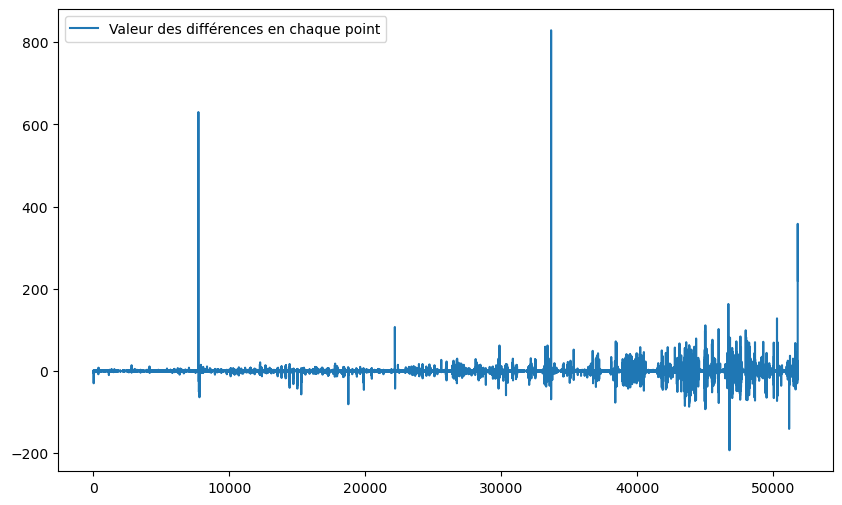

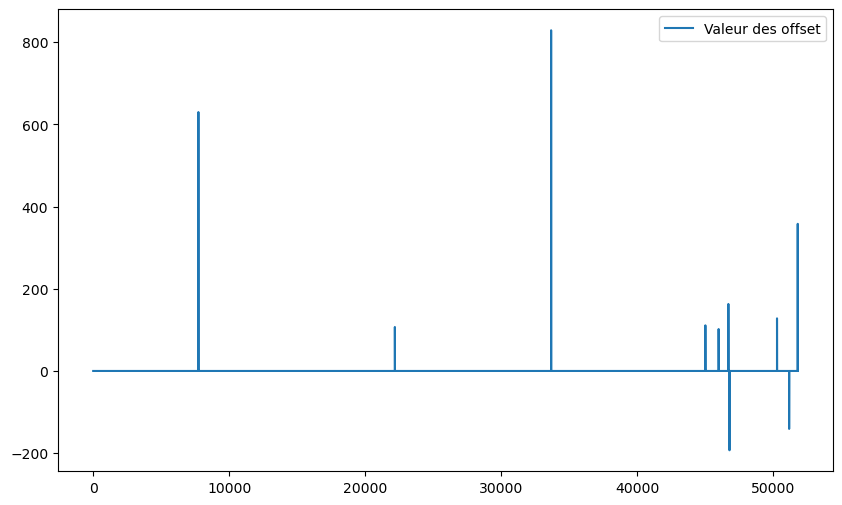

In [211]:
# Valeur des offset
data_diff = []
data_offset = []
k = 0
for i in range(0,len(data_clean)-1):
    data_diff.append(data_clean[i+1]-data_clean[i])
    if i == offset[k] : 
        data_offset.append(data_clean[i]-data_clean[i-1])
        if k < len(offset) -1 :
            k += 1
    else : 
        data_offset.append(0)
    
   
# Transformation en série temporelle
time_serie_diff = pd.Series(data_diff, dtype='float64')
time_serie_offset = pd.Series(data_offset, dtype='float64')

# Affichage de la série diff
plt.figure(figsize=(10, 6))
plt.plot(time_serie_diff, label='Valeur des différences en chaque point')
plt.legend()
plt.show()

# Affichage de la série offset
plt.figure(figsize=(10, 6))
plt.plot(time_serie_offset, label='Valeur des offset')
plt.legend()
plt.show()

### Technique du chat (GPT)

#### Ajustement de l'offset

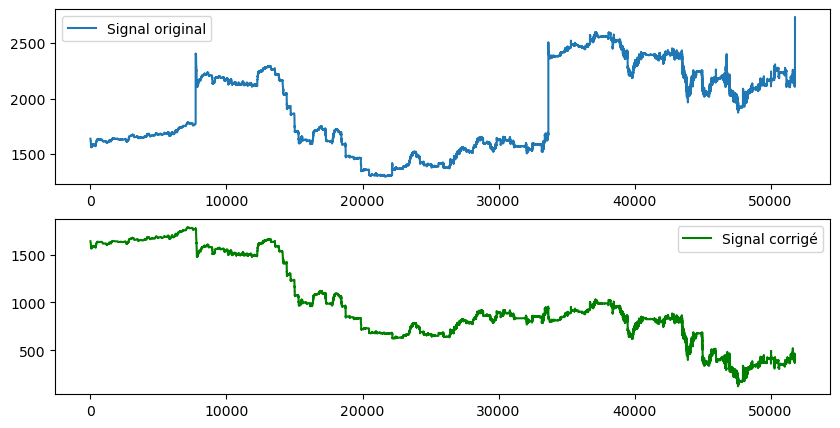

In [231]:
import numpy as np
import matplotlib.pyplot as plt

# Seuil de détection de saut (valeur à ajuster selon ton signal)
seuil_offset = 100

# Détection des sauts
sauts = np.where(np.abs(np.diff(data_clean)) > seuil_offset)[0]

# Correction du signal
data_ajust = data_clean.copy()
for saut in sauts:
    # Ajuster les valeurs après le saut en supprimant l'offset
    offset = data_ajust[saut+1] - data_ajust[saut]
    data_ajust[saut+1:] -= offset

# Visualisation avant et après correction
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(data_clean, label="Signal original")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data_ajust, label="Signal corrigé", color='green')
plt.legend()
plt.show()


#### Interpolation

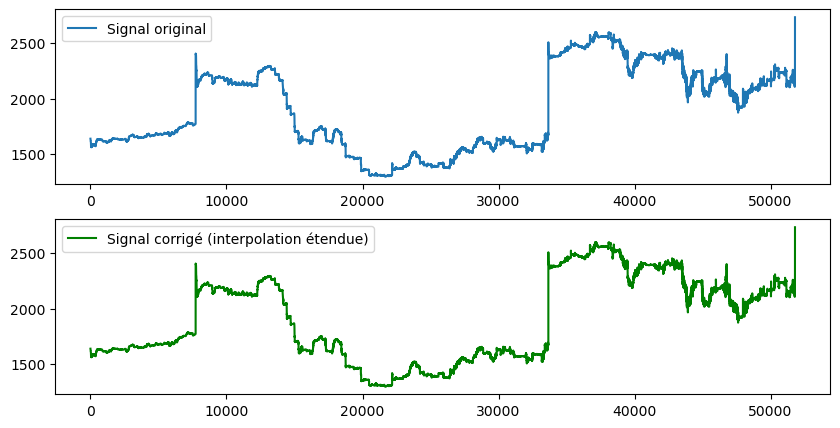

In [238]:
from scipy.interpolate import interp1d

# Seuil de détection de saut (valeur à ajuster selon ton signal)
seuil_offset = 100

# Détection des sauts
sauts = np.where(np.abs(np.diff(data_clean)) > seuil_offset)[0]

data_interpol = data_clean.copy()

# Nombre de points à utiliser avant et après le saut pour l'interpolation
plage_interpolation = 5  # Ajuster cette valeur selon ton signal

for saut in sauts:
    # Définir les limites de l'intervalle d'interpolation
    start = max(0, saut - plage_interpolation)
    end = min(len(data_clean) - 1, saut + plage_interpolation + 1)
    
    # Points avant et après le saut sur un plus large intervalle
    x_vals = np.arange(start, end)
    y_vals = data_clean[start:end]
    
    # Interpolation linéaire (ou choisir une interpolation cubique, etc.)
    interp = interp1d(x_vals, y_vals, kind='linear', fill_value="extrapolate")
    
    # Appliquer l'interpolation sur cette portion
    data_interpol[start:end] = interp(np.arange(start, end))

# Visualisation avant et après correction
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(data_clean, label="Signal original")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data_interpol, label="Signal corrigé (interpolation étendue)", color='green')
plt.legend()
plt.show()


#### Filtrage (passe-bas)

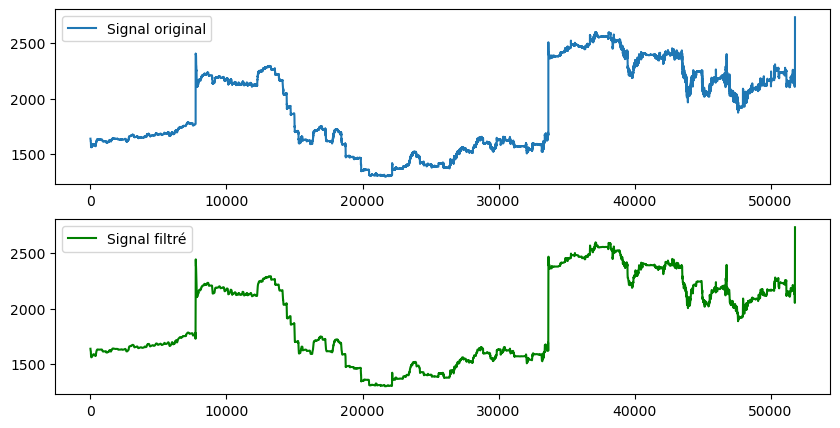

In [274]:
from scipy.signal import butter, filtfilt

# Paramètres du filtre
ordre = 4
frequence_coupure = 0.1 # A ajuster selon ton signal

# Création du filtre passe-bas
b, a = butter(ordre, frequence_coupure, btype='low', analog=False)

# Application du filtre
data_filtre = filtfilt(b, a, data_clean)

# Visualisation avant et après filtrage
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(data_clean, label="Signal original")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data_filtre, label="Signal filtré", color='green')
plt.legend()
plt.show()

### On interpole

7731 1773
7732 1773
7733 2325
7734 3021
22176 1313
22177 1313
33664 1671
33665 1676
33666 3075
33667 2778
45006 2089
45980 2161
46697 2103
46779 2363
50272 2166
51164 2249
51165 2251
51166 2123
51167 2362
51642 2258
51643 2213
51644 2342
51645 2206
51801 2117
51802 2130
51803 2976
51805 2488


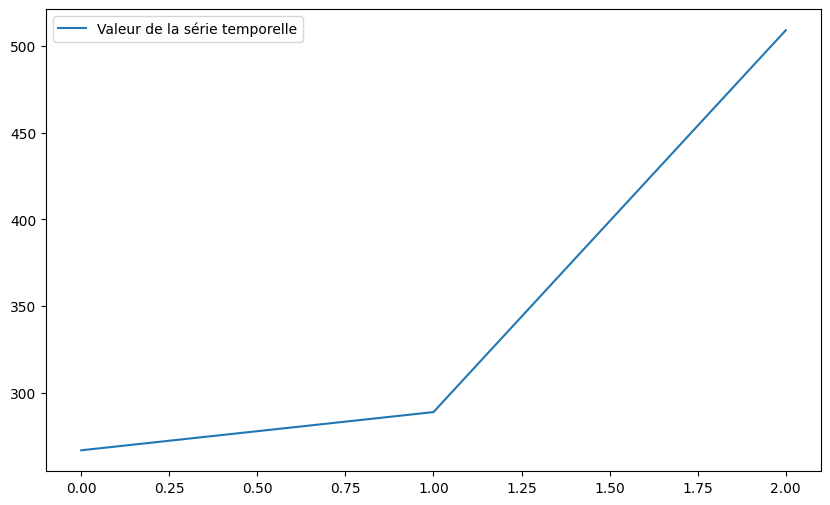

In [193]:
data_clean = delete_pic(data_crop,indices)

time_serie_clean = pd.Series(data_clean, dtype='float64')

plt.figure(figsize=(10, 6))
plt.plot(time_serie_clean, label='Valeur de la série temporelle')
plt.legend()
plt.show()

# Première modélisation naïve

In [9]:
# SARIMA parameters
p, d, q = 1, 1, 1    
P, D, Q, s = 1, 1, 1, 96  # Seasonality every 96 time steps

# Building the SARIMA model
model = SARIMAX(time_serie, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)

# Display the model summary
print(model_fit.summary())

KeyboardInterrupt: 